## Corresponding TFX Libraries

## Instal Some Dependencies & Import Librarys 

In [1]:
!pip install -q -U \
  tensorflow==2.4.1 \
  tfx==0.28.0

In [2]:
import os
import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate=False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from typing import Dict, List, Text
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.utils.dsl_utils import external_input


import seaborn as sns
import matplotlib.pyplot as plt


%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip
%matplotlib inline

In [3]:
def ensure_dir(directory: str):
    if (len(directory) > 0 and not os.path.exists(directory)):
        os.makedirs(directory)

In [4]:
tfx_path = "/content/tfx"
ensure_dir(tfx_path)
pipeline_path = os.path.join(tfx_path, "pipelines")
ensure_dir(pipeline_path)
metadata_path = os.path.join(tfx_path, "metadata")
ensure_dir(metadata_path)
logs_path = os.path.join(tfx_path, "logs")
ensure_dir(logs_path)
data_path = os.path.join(tfx_path, "data")
ensure_dir(data_path)
serving_model_path = os.path.join(tfx_path, "serving_model")
ensure_dir(serving_model_path)

## Download & Get Taxi Trip Dataset

In [5]:
raw_data_path = "/content/data.csv"

In [6]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv -q

In [7]:
df = pd.read_csv(raw_data_path)

df.head()

,pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
0,NaN,12.45,5,19,6,1400269500,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,0.0,NaN,0.0
1,NaN,0.00,3,19,5,1362683700,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Unknown,Chicago Elite Cab Corp.,300.0,NaN,0.0
2,60.0,27.05,10,2,3,1380593700,41.836150,-87.648788,NaN,NaN,12.6,NaN,NaN,Cash,Taxi Affiliation Services,1380.0,NaN,0.0
3,10.0,5.85,10,1,2,1382319000,41.985015,-87.804532,NaN,NaN,0.0,NaN,NaN,Cash,Taxi Affiliation Services,180.0,NaN,0.0
4,14.0,16.65,5,7,5,1369897200,41.968069,-87.721559,NaN,NaN,0.0,NaN,NaN,Cash,Dispatch Taxi Affiliation,1080.0,NaN,0.0


## Data Wrabling

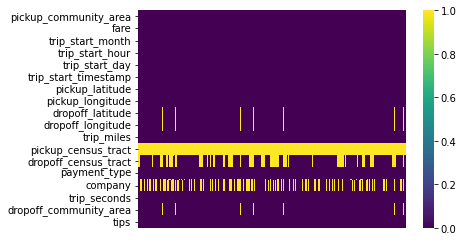

In [8]:
sns.heatmap(df.isnull().T, xticklabels=False, cmap="viridis")

In [9]:
df.isnull().sum()

pickup_community_area         2
fare                          0
trip_start_month              0
trip_start_hour               0
trip_start_day                0
trip_start_timestamp          0
pickup_latitude               2
pickup_longitude              2
dropoff_latitude            483
dropoff_longitude           483
trip_miles                    0
pickup_census_tract       15001
dropoff_census_tract       4241
payment_type                  0
company                    5140
trip_seconds                  6
dropoff_community_area      507
tips                          0
dtype: int64

In [10]:
df = df.drop(["trip_start_timestamp", "trip_miles", "pickup_census_tract",
              "dropoff_census_tract", "trip_seconds", "payment_type",
              "tips", "company", "dropoff_community_area", "pickup_community_area"], axis=1)

df = df.dropna()

## Get Train & Test Set (Save in data)

**Note:** TFX internally splits train and validation data.

In [11]:
np.random.seed(seed=7)
msk = np.random.rand(len(df)) < 0.9

traindf = df[msk]
testdf = df[~msk]

print("\t Number of Samples at Train and Test Set")
print(f"  * Train: {len(traindf)};\n  * Test: {len(testdf)}.")

	 Number of Samples at Train and Test Set
  * Train: 13044;
  * Test: 1475.


In [12]:
traindf.to_csv(os.path.join(data_path, "train.csv"), index=False, header=True)
testdf.to_csv("test.csv", index=False, header=True)

## Setup pipeline paths & Create the InteractiveContext

In [13]:
_tfx_root = os.path.join(os.getcwd(), "tfx")
_pipeline_root = os.path.join(_tfx_root, "pipelines")
_metadata_db_root = os.path.join(_tfx_root, "metadata.db")
_log_root = os.path.join(_tfx_root, "logs")
_model_root = os.path.join(_tfx_root, "model")
_data_root = os.path.join(_tfx_root, "data")
_serving_model_dir = os.path.join(_tfx_root, "serving_model")
_data_filepath = os.path.join(_data_root, "train.csv")

_input_fn_module_file = "inputfn_trainer.py"
_constants_module_file = "constants_trainer.py"
_model_trainer_module_file = "model_trainer.py"

**Create Interactive Context**

In [14]:
context = InteractiveContext(pipeline_root=_tfx_root)

## Run TFX components interactively

**ExampleGen**

1.   Split data into training and evalutation sets (by default 2/3 training + 1/3 evalution);
2.   Convert data into the `tf.example` format;
3.   Copy splits into the `_tfx_root` directory for other components to access.




In [15]:
example_gen = CsvExampleGen(input=external_input(_data_root))

context.run(example_gen)

Instructions for updating:
external_input is deprecated, directly pass the uri to ExampleGen.


ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 5
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 5
        type_id: 5
        uri: "/content/tfx/CsvExampleGen/examples/5"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:904439,xor_checksum:1632151473,sum_checksum:1632151473"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [16]:
artifact = example_gen.outputs["examples"].get()[0]

print(artifact.split_names, artifact.uri)

["train", "eval"] /content/tfx/CsvExampleGen/examples/5


**StatisticsGen**

In [17]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs["examples"]
)

context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 6
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 6
        type_id: 7
        uri: "/content/tfx/StatisticsGen/statistics/6"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 7
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [18]:
context.show(statistics_gen.outputs["statistics"])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


## SchemaGen

In [19]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs["statistics"],
    infer_feature_shape=False
)

context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 7
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 7
        type_id: 9
        uri: "/content/tfx/SchemaGen/schema/7"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 9
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [20]:
context.show(schema_gen.outputs["schema"])

,Type,Presence,Valency,Domain
Feature name,,,,
'dropoff_latitude',FLOAT,required,single,-
'dropoff_longitude',FLOAT,required,single,-
'fare',FLOAT,required,single,-
'pickup_latitude',FLOAT,required,single,-
'pickup_longitude',FLOAT,required,single,-
'trip_start_day',INT,required,single,-
'trip_start_hour',INT,required,single,-
'trip_start_month',INT,required,single,-


## ExampleValidator

In [21]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs["statistics"],
    schema=schema_gen.outputs["schema"]
)

context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 8
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 8
        type_id: 11
        uri: "/content/tfx/ExampleValidator/anomalies/8"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 11
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [22]:
context.show(example_validator.outputs["anomalies"])

/usr/local/lib/python3.7/dist-packages/tensorflow_data_validation/utils/display_util.py:188: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


## Transform



In [23]:
bins_lat = pd.qcut(list(df["dropoff_latitude"].values) + list(df["pickup_latitude"].values), q=20, duplicates="drop", retbins=True)[1]
bins_lon = pd.qcut(list(df["dropoff_longitude"].values) + list(df["pickup_longitude"].values), q=20, duplicates="drop", retbins=True)[1]

In [24]:
code = """
bins_lat = {bins_lat}
bins_lon = {bins_lon}
"""

code = code.replace("{bins_lat}", str(list(bins_lat)))
code = code.replace("{bins_lon}", str(list(bins_lon)))

with open(_constants_module_file, "w") as writefile:
    writefile.write(code)


## Trainer

In [25]:
%%writefile {_input_fn_module_file}
import os
import tensorflow as tf


# Feature Engineering
def feature_engg_features(features):
    features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5
    features['trip_start_month'] = tf.strings.as_string(features['trip_start_month'])
    features['trip_start_hour'] = tf.strings.as_string(features['trip_start_hour'])
    features['trip_start_day'] = tf.strings.as_string(features['trip_start_day'])

    return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)

def make_input_fn(dir_uri, mode, vnum_epochs = None, batch_size = 512):
    def decode_tfr(serialized_example):
      # 1. define a parser
      features = tf.io.parse_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'dropoff_latitude': tf.io.FixedLenFeature([], tf.float32),
            'dropoff_longitude': tf.io.FixedLenFeature([], tf.float32),
            'fare': tf.io.FixedLenFeature([], tf.float32),
            'pickup_latitude': tf.io.FixedLenFeature([], tf.float32, default_value = 0.0),
            'pickup_longitude': tf.io.FixedLenFeature([], tf.float32, default_value = 0.0),
            'trip_start_day': tf.io.FixedLenFeature([], tf.int64),
            'trip_start_hour': tf.io.FixedLenFeature([], tf.int64),
            'trip_start_month': tf.io.FixedLenFeature([], tf.int64)
        })

      return features, features['fare']

    def _input_fn(v_test=False):
      # Get the list of files in this directory (all compressed TFRecord files)
      tfrecord_filenames = tf.io.gfile.glob(dir_uri)

      # Create a `TFRecordDataset` to read these files
      dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

      if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = vnum_epochs # indefinitely
      else:
        num_epochs = 1 # end-of-input after this

      dataset = dataset.batch(batch_size)
      dataset = dataset.prefetch(buffer_size = batch_size)

      #Convert TFRecord data to dict
      dataset = dataset.map(decode_tfr)

      #Feature engineering
      dataset = dataset.map(feature_engg)

      if mode == tf.estimator.ModeKeys.TRAIN:
          num_epochs = vnum_epochs # indefinitely
          dataset = dataset.shuffle(buffer_size = batch_size)
      else:
          num_epochs = 1 # end-of-input after this

      dataset = dataset.repeat(num_epochs)       
      
      #Begins - Uncomment for testing only -----------------------------------------------------<
      if v_test == True:
        print(next(dataset.__iter__()))
        
      #End - Uncomment for testing only -----------------------------------------------------<
      return dataset
    return _input_fn

Overwriting inputfn_trainer.py


In [26]:
##Test the input function
import inputfn_trainer as ift

#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'eval/*')
fn_d = ift.make_input_fn(dir_uri = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

({'dropoff_latitude': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41.920452, 41.920452, 42.00157 , 42.00157 , 42.00157 , 41.97244 ,
       41.89251 , 41.89251 , 41.957737, 41.957737], dtype=float32)>, 'dropoff_longitude': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-87.679955, -87.679955, -87.695015, -87.695015, -87.695015,
       -87.67111 , -87.62621 , -87.62621 , -87.683716, -87.683716],
      dtype=float32)>, 'fare': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([12.25,  6.05,  7.45,  3.45,  9.85, 12.25,  6.45,  9.45,  9.05,
        6.05], dtype=float32)>, 'pickup_latitude': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41.952824, 41.906025, 41.97517 , 42.00157 , 41.968067, 41.90838 ,
       41.89266 , 41.929264, 41.92862 , 41.94914 ], dtype=float32)>, 'pickup_longitude': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-87.653244, -87.67531 , -87.687515, -87.695015, -87.72156 ,
       -87.670944, -87.652534, -87.63589 , -87.68536 , -87.65681

<RepeatDataset shapes: ({dropoff_latitude: (None,), dropoff_longitude: (None,), fare: (None,), pickup_latitude: (None,), pickup_longitude: (None,), trip_start_day: (None,), trip_start_hour: (None,), trip_start_month: (None,), distance: (None,)}, (None,)), types: ({dropoff_latitude: tf.float32, dropoff_longitude: tf.float32, fare: tf.float32, pickup_latitude: tf.float32, pickup_longitude: tf.float32, trip_start_day: tf.string, trip_start_hour: tf.string, trip_start_month: tf.string, distance: tf.float32}, tf.float32)>